In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### 定义函数

In [37]:
# 显示图像
def cv_show(name,img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# resize图像
def resize(image, width= None, height= None, inter= cv2.INTER_AREA):
    dim= None
    (h,w)= image.shape[:2] # image.shape returns h,w
    if width is None and height is None:
        return image
    if width is None:
        r= height/float(h)
        width= int(r*w)
        dim= (width, height)
    else:
        r= width/(float(w))
        height= int(h*r)
        dim= (width, height)
    resized= cv2.resize(image, dim, interpolation=inter) # but dim should be passed as w,h
    return resized


### 准备数字模板

10


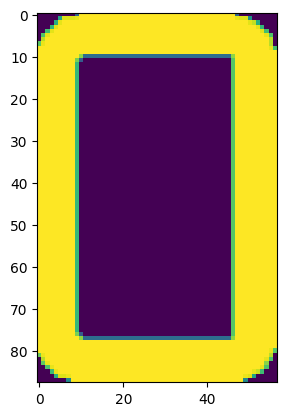

In [38]:
# 读取模板
img= cv2.imread('ocr_a_reference.png')
cv_show("template", img)

# 灰度图
ref= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv_show("ref", ref)

# 二值图
ref= cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
cv_show("gray", ref)

# 计算轮廓
# cv2.CHAIN_APPROX_SIMPLE使返回结果中只保留直线的起点和终点
# hierarchy返回该contour的上一个contour，下个contour，parent contour和child contour。如无则返回-1
contours, hierarchy= cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0, 0, 255), 3)
cv_show("img", img)
print(len(contours)) 

# 将轮廓排序，从左到右
# 先将轮廓用最小的矩形包围起来, x, y, w, h
boundingBoxes= [cv2.boundingRect(c) for c in contours]
# 将contours和boundingBoxes给zip在一起，然后用sorted(zipped file, key)来排序，最后用zip(*)来逆zip
contours, boundingBoxes=zip(*sorted(zip(contours, boundingBoxes), key= lambda pair: pair[1][0]))

# 将矩形调整成适合的大小，并且把template连接上数字
digits={}
for i, c in enumerate(contours):
    x, y, w, h= cv2.boundingRect(c) # x,y是矩形左上角的坐标，在图像处理中，往右和往下x和y会增大
    roi= ref[y:y+h, x: x+w]  # rows are equivalent to y, columns are equivalent to x
    roi= cv2.resize(roi, (57,88))
    digits[i]= roi

# show sample
plt.imshow(digits[0])


### 处理信用卡图片

#### 为了能定位数字区域对图像进行预处理

In [39]:
# 初始化卷积核
rectKernal= cv2.getStructuringElement(cv2.MORPH_RECT,(9,3))
sqKernal= cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

In [40]:
# 读取信用卡图像
image= cv2.imread("images/credit_card_01.png")
cv_show("image", image)

# resize image并且灰度化
image= resize(image, width= 300)
gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv_show("gray", gray)

In [41]:
# tophat操作，突出更明亮的区域
# blackhat操作，突出比较暗的区域
tophat= cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernal)
cv_show("tophat", tophat)

In [42]:
# 用sobel算子来找出边界, ddepth表示输出图像的精度，由于sobel计算梯度可能导致结果为负，因而需要制定输出图像精度
gradx= cv2.Sobel(tophat, ddepth= cv2.CV_32F, dx=1, dy=0, ksize=3)
gradx= np.absolute(gradx)
minVal, maxVal= np.min(gradx), np.max(gradx)
gradx= (gradx-minVal)/(maxVal- minVal)*255
gradx= gradx.astype("uint8") # uint8是非负数的8位数，其范围从0到255
cv_show("gradx", gradx)

In [43]:
# 通过闭操作将数字连在一起
gradx= cv2.morphologyEx(gradx, cv2.MORPH_CLOSE, rectKernal)
cv_show("gradx",gradx)

In [44]:
# Thresh_otsu会自动寻找合适的阈值，适合双峰，需要把阈值参数设置为0
_, thresh = cv2.threshold(gradx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv_show('thresh',thresh)

In [45]:
# 再来一个闭操作
thresh= cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernal)
cv_show('thresh',thresh)

#### 定位数字区域

In [46]:
# 计算轮廓
contours, hierarchy= cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cur_img= image.copy()
cv2.drawContours(cur_img, contours, -1, (0,0,255), 3)
cv_show("img", cur_img)

In [47]:
locs=[]
for i,c in enumerate(contours):
    # 计算矩形
    x,y,w,h= cv2.boundingRect(c)
    ar= w/float(h)

    #根据数字区块的长宽比来选择目标区域
    if ar> 2.5 and ar< 4:
        if (w> 40 and w< 55) and (h>10 and h<20):
            locs.append((x,y,w,h))

# 将符合的轮廓从左到又排序
locs= sorted( locs, key= lambda x: x[0])

In [48]:
# 遍历每一个轮廓中的数字和模板进行匹配，并且记录

for (i, (gx,gy,gw,gh)) in enumerate(locs):
    
    groupOutput=[]

    # 选取每个数组的范围
    group= gray[gy-5: gy+ gh+5, gx-5: gx+ gw+5]

    # 将图像二值化
    _, group= cv2.threshold(group, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 进行轮廓和外接矩形计算，并且进行从左到右的排序
    contours, hierarchy= cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes= [cv2.boundingRect(c) for c in contours]
    contours, boundingBoxes=zip(*sorted(zip(contours, boundingBoxes), key= lambda pair: pair[1][0]))

    for i, (x,y,w,h) in enumerate(boundingBoxes):

        roi= group[y: y+h, x: x+w]
        roi= cv2.resize(roi, (57,88))
        scores=[]
        for digit, digitROI in digits.items():
            result= cv2.matchTemplate(roi, digitROI,cv2.TM_CCOEFF)
            scores.append(result[0][0])
        groupOutput.append(str(np.argmax(scores)))

        cv2.rectangle(image, (gx - 5, gy - 5),(gx + gw + 5, gy + gh + 5), (0, 0, 255), 1)
        cv2.putText(image, "".join(groupOutput), (gx-10,  gy - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

print("".join(groupOutput))
        


9010


In [50]:
cv_show("",image)